<a href="https://colab.research.google.com/github/Geek-a-Byte/Bengali-Speech-to-Sign-Language-Translator-For-Hearing-Impaired/blob/main/Bengali_Sign_Language_Recognition_Using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> https://www.kaggle.com/datasets/muntakimrafi/bengali-sign-language-dataset


## Installing dependencies and Required Imports

In [ ]:
# The Pillow library contains all the basic image processing functionality. You can do image resizing, rotation and transformation.

# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall Pillow
# install the new one
!pip install Pillow==5.3.0

In [ ]:
# import the new one
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
# since the input images are quite large, we will disable the size check
PIL.Image.MAX_IMAGE_PIXELS = None

In [ ]:
# PyTorch is an open source machine learning library used for developing and training neural network based deep learning models. 
# It is primarily developed by Facebook's AI research group. PyTorch can be used with Python as well as a C++. 
# Naturally, the Python interface is more polished.

# Torchvision is a library for Computer Vision that goes hand in hand with PyTorch. 
# It has utilities for efficient Image and Video transformations, some commonly used pre-trained models, 
# and some datasets ( torchvision does not come bundled with PyTorch, you will have to install it separately. )

# https://tinyurl.com/25ufu7jk

!pip install torchvision
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports here

# cv2 is the module import name for opencv-python, "Unofficial pre-built CPU-only OpenCV packages for Python". 
import cv2

# What is Shutil in Python?
# Shutil module offers high-level operation on a file like a copy, create, and remote operation on the file. 
# It comes under Python's standard utility modules. This module helps in automating the process of copying and removal of files and directories.
import shutil 

# The OS module in Python provides functions for creating and removing a directory (folder), 
# fetching its contents, changing and identifying the current directory, etc. 
# You first need to import the os module to interact with the underlying operating system.
import os

import time
from datetime import datetime
from pytz import timezone  

# An OrderedDict is a dictionary subclass that remembers the order that keys were first inserted. 
# The only difference between dict() and OrderedDict() is that:

# OrderedDict preserves the order in which the keys are inserted. 
# A regular dict doesn’t track the insertion order and iterating 
# it gives the values in an arbitrary order. By contrast, the order the items are inserted is remembered by OrderedDict.

# https://tinyurl.com/y9fk9re3

from collections import OrderedDict

# The main motive is to create a copy of Python object that we can modify the copy without changing the original data. 
# In Python, there are two methods to create copies.

# Shallow Copy
# Deep Copy
# We will use the copy module to create the above copies.

# A shallow copy is a copy of an object that stores the reference of the original elements. 
# It creates the new collection object and then occupying it with reference to the child objects found in the original.
# It makes copies of the nested objects' reference and doesn't create a copy of the nested objects. 
# So if we make any changes to the copy of the object will reflect in the original object. 
# We will use the copy() function to implement it.

# A deep copy is a process where we create a new object and add copy elements recursively. 
# We will use the deecopy() method which present in copy module. 
# The independent copy is created of original object and its entire object.
# https://tinyurl.com/2nryk85q
import copy


import torch

# torch.cuda. empty_cache ()[source] Releases all unoccupied cached memory currently held by the caching allocator 
# so that those can be used in other GPU application and visible in nvidia-smi . 
# empty_cache() doesn't increase the amount of GPU memory available for PyTorch.
torch.cuda.empty_cache()
import torchvision

# The torch. nn import gives us access to some helpful neural network things,
# such as various neural network layer types (things like regular fully-connected layers, convolutional layers (for imagery), recurrent layers...etc).
import torch.nn as nn

# torch.optim is a package implementing various optimization algorithms.
import torch.optim as optim

# The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
from torchvision import datasets, models, transforms

# Variables are just wrappers for the tensors so you can now easily auto compute the gradients.

# Think of tensors and variables as same thing. Variables are just wrappers for the tensors so you can now easily auto compute the gradients.
# So if a tensor was batman…
# A Variable would be batman but with his utility belt on…:grin:
# Batman can do the job but if he has his utility belt on he’s got cool gadgets to use😉

# torch tensors are actually the data.
# variables wrap tensors, and construct a chain of operations between the tensors, so that the gradients can flow back.
# so, eg you create variable a, and then add 1 to it to get b. Theres now a link stored between a and b, in the creator property of b. Then when you call .backward() on b, 
# the gradient backpropagates, via the function in b.creator into a.
# tensors dont have the concept of gradients, creator etc. they purely store data, and handle operations on that data, like adding, multiplying and stuff.

# https://tinyurl.com/2r2uz6xr
# https://tinyurl.com/2j6keuvm

from torch.autograd import Variable

# torch.optim.lr_scheduler provides several methods to adjust the learning rate based on the number of epochs.
from torch.optim import lr_scheduler

# the SubsetRandomSampler uses randomly select samples from indices. 
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected: ", device)

selected:  cuda


## Loading and Formatting the dataset

[**dataset link**](https://www.kaggle.com/datasets/muntakimrafi/bengali-sign-language-dataset)





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/CSE 442/BSL.zip" -d "./BSL/"

## Creating Dataloaders


In [ ]:
# All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
# The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

# https://tinyurl.com/2ndu68yt
# https://tinyurl.com/2pljaewl

data_transforms = {
    'train': transforms.Compose([
        # Crop the images to be of size (224, 224) and convert them to tensors.
        transforms.Resize((224,224)),
        # This just converts your input image to PyTorch tensor.
        transforms.ToTensor(), 
        # This is just input data scaling and these values (mean and std) must have been precomputed for your dataset. Changing these values is also not advised.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # First your input image is resized to be of size (256, 256)
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms

In [ ]:
# data_dir = '/content/CervicalCancerSplitDataset/content/CervicalCancerSplitDataset'
data_dir ='/content/BSL'

# image bhag kore rakhtesi train and validation er jonno

# {x: "data/hymenoptera_data/"+x for x in ['train', 'val']}
# The results will be:
# {'train': 'data/hymenoptera_data/train', 'val': 'data/hymenoptera_data/val'}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    ) 
    for x in ['train', 'test']
}

for x in ['train', 'test']:
    print(x) # train\nvalid
    print(image_datasets[x])

# Now, we will pass the samplers to our dataloader. Note that shuffle=True cannot be used when you're using the SubsetRandomSampler.
# DataLoader(
#     dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

# 1. Dataset: The first parameter in the DataLoader class is the dataset. This is where we load the data from.
# 2. Batching the data: batch_size refers to the number of training samples used in one iteration. Usually we split our data into training and testing sets, and we may have different batch sizes for each.
# 3. Shuffling the data: shuffle is another argument passed to the DataLoader class. The argument takes in a Boolean value (True/False). If shuffle is set to True, then all the samples are shuffled and loaded in batches. Otherwise they are sent one-by-one without any shuffling.
# 4. Allowing multi-processing: As deep learning involves training models with a lot of data, running only single processes ends up taking a lot of time. In PyTorch, you can increase the number of processes running simultaneously by allowing multiprocessing with the argument num_workers. This also depends on the batch size, but I wouldn’t set num_workers to the same number because each worker loads a single batch, and returns it only once it’s ready.
# 5. Merging datasets: The collate_fn argument is used if we want to merge datasets. This argument is optional, and mostly used when batches are loaded from map-styled datasets.
# 6. Loading data on CUDA tensors: You can directly load datasets as CUDA tensors using the pin_memory argument. It is an optional parameter that takes in a Boolean value; if set to True, the DataLoader class copies Tensors into CUDA-pinned memory before returning them.

# num_workers=0 means that it’s the main process that does the data loading when needed.
# num_workers=1 means you only have a single worker, so it might be slow.

# https://tinyurl.com/2homvwhv

dataloaders = {
    x: torch.utils.data.DataLoader(
       image_datasets[x], 
       batch_size=32,
       shuffle=True, 
       num_workers=4
    )
    for x in ['train', 'test']
}

# or this syntax
# dataloaders = {
#     'train': torch.utils.data.DataLoader(
#         image_datasets['train'],
#         batch_size=4,
#         shuffle=True,
#         num_workers=0
#     ),
#     'val': torch.utils.data.DataLoader(
#         image_datasets['valid'],
#         batch_size=4,
#         shuffle=True,
#         num_workers=0
#     )
# }
 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes 
len(class_names)

train
Dataset ImageFolder
    Number of datapoints: 11061
    Root location: /content/BSL/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
test
Dataset ImageFolder
    Number of datapoints: 1520
    Root location: /content/BSL/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


38

## Explore the data

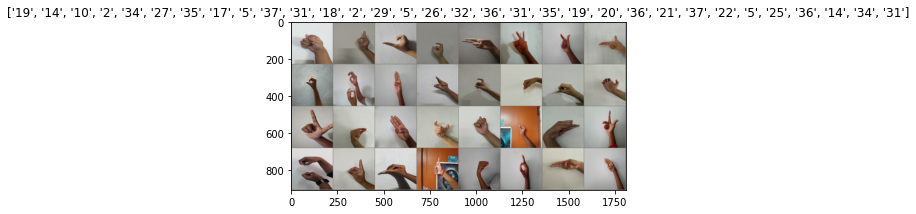

In [ ]:
def imshow(img, title=None):
    """Imshow for Tensor. ei function tensor e converted image kei abar image hishebe show koracche"""
    
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)  # pause a bit so that plots are updated


# dataloaders['train'] is a iterable, passing it to iter() returns an iterator which you can iterate trough. 
# You could separate the two functions to better understand what is happening. i = iter(dataloaders['train']) and then next(i).
# If you're running this interactively in a notebook try running next(i) a few more times. 
# Each time you run next(i) it will return the next batch of size 32 of the iterator until there are no batches left. 

# The DataLoader is a function that iterates through all our available data and returns it in the form of batches. For example, if we have a dataset of 32 images, and we decide to batch the data with a size of 4. Our DataLoader would process the data, and return 8 batches of 4 images each.
# The Dataset class is an abstract class representing the dataset. It allows us to treat the dataset as an object of a class, rather than a set of data and labels. Dataset class returns a pair of [input, label] every time it is called. 

# To access an individual batch from the DataLoader, we first pass the DataLoader object to Python’s iter() built-in function, which returns an object representing a stream of data.
# Iterator object allows you to traverse through all the elements of a DataLoader, regardless of its specific implementation. An iterator is an object representing a stream of data. You can create an iterator object by applying the iter() built-in function to an iterable.
# With the stream of data, we can use Python built-in next() function to get the next data element in the stream of data. From this, we are expecting to get a batch of samples.
# We can get the next element in a sequence without keeping the entire dataset in memory.
# You can use an iterator to manually loop over the iterable it or repeated passing of an iterator to the built-in function next() returns successive items in the stream. Once, when you consumed an item from an iterator, it’s gone. When no more data are available a StopIteration exception is raised.

# Get a batch of training data, of size 32 as set in the dataloader
# Every call to the dataset iterator will return batch of images of size batch_size. 
# Hence you will have 32 batches
# each batch has at least 88 images 
# so iter iterates until you exhaust all the 88*32=2816 images.

# https://tinyurl.com/2jafjskv
# https://tinyurl.com/2njaph88
# https://tinyurl.com/2jhnpzjl

dataiter = iter(dataloaders['train'])
inputs, classes = next(dataiter)

# print(len(inputs)) # 32
# print(classes) # tensor([2, 4, 0, 4, 3, 1, 4, 3, 2, 3, 2, 1, 0, 2, 2, 3, 0, 2, 3, 2, 0, 3, 3, 3, 4, 0, 0, 1, 1, 0, 4, 1]) will be same as image tiles, tho changes in every run
# print(sum(1 for _ in dataiter)) # 88

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train Model

In [ ]:
# set timezone
my_timezone = timezone('Asia/Dhaka')

In [ ]:
train_Acc, train_Loss, val_Acc, val_Loss = [], [], [], []

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    train_Acc.clear()
    train_Loss.clear()
    val_Acc.clear()
    val_Loss.clear()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{} at {}'.format(epoch, num_epochs - 1, datetime.now(my_timezone).strftime('%I:%M:%S %p (%d %b %Y)')))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
              train_Acc.append(epoch_acc)
              train_Loss.append(epoch_loss)
            else:
              val_Acc.append(epoch_acc)
              val_Loss.append(epoch_loss)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## densenet121

---



In [ ]:
# super simplified
model_densenet = models.densenet121(pretrained=True)

for param in model_densenet.parameters():
  param.requires_grad = True

model_densenet.classifier = nn.Linear(1024,38)
model_densenet = model_densenet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# We create an optimizer, in this case, SGD with a learning rate of 0.006 and register all the parameters of the model in the optimizer. Observe that all parameters are being optimized
optimizer = optim.SGD(model_densenet.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
# lr = 0.006 if epoch < 3
# lr = 0.0006 if 3 <= epoch < 6
# lr = 0.00006 if 6 <= epoch < 9
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model_densenet = train_model(model_densenet, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4 at 09:30:13 AM (01 Dec 2022)
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6928 Acc: 0.8130
test Loss: 0.3890 Acc: 0.8776
Epoch 1/4 at 09:32:24 AM (01 Dec 2022)
----------
train Loss: 0.1635 Acc: 0.9518
test Loss: 0.2461 Acc: 0.9224
Epoch 2/4 at 09:34:31 AM (01 Dec 2022)
----------
train Loss: 0.0625 Acc: 0.9848
test Loss: 0.1211 Acc: 0.9645
Epoch 3/4 at 09:36:37 AM (01 Dec 2022)
----------
train Loss: 0.0405 Acc: 0.9896
test Loss: 0.1233 Acc: 0.9632
Epoch 4/4 at 09:38:44 AM (01 Dec 2022)
----------
train Loss: 0.0327 Acc: 0.9920
test Loss: 0.1154 Acc: 0.9658
Training complete in 10m 38s
Best val Acc: 0.965789


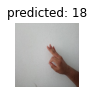

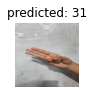

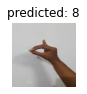

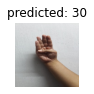

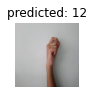

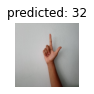

In [ ]:
visualize_model(model_densenet)

In [ ]:
torch.save(model_densenet.state_dict(), "BSL_densenet121.pt")

###### performance metrics for DenseNet121 

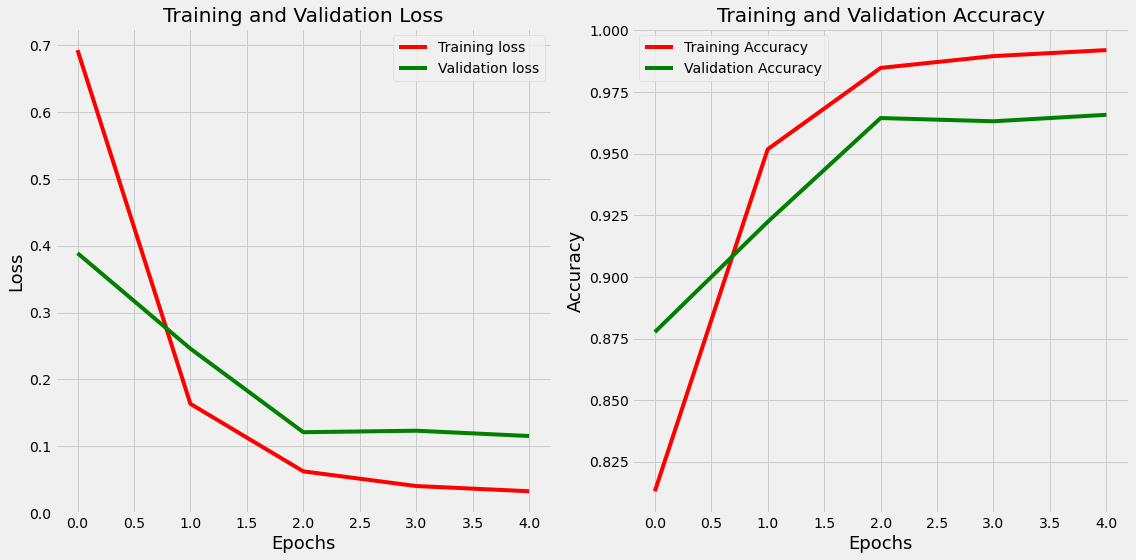

In [ ]:
def plot_auc_acc_loss(epochs):

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, train_Loss, 'r', label='Training loss')
    axes[0].plot(Epochs, val_Loss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    train_Acc2=torch.FloatTensor(train_Acc).detach().cpu().numpy()
    val_Acc2=torch.FloatTensor(val_Acc).detach().cpu().numpy()
    axes[1].plot(Epochs, train_Acc2, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, val_Acc2, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()


    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(epochs=5)

In [106]:
correct = 0
total = 0

predictions_list = []
labels_list = []
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        labels_list.append(labels) 
        outputs = model_densenet(images)
        
        _, predicted = torch.max(outputs.data, 1)
        predictions_list.append(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test images:  96.57894736842105 %


In [107]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [108]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        40
           1       1.00      0.95      0.97        40
           2       1.00      0.97      0.99        40
           3       0.98      1.00      0.99        40
           4       0.89      0.85      0.87        40
           5       0.97      0.97      0.97        40
           6       0.97      0.95      0.96        40
           7       0.97      0.97      0.97        40
           8       0.95      0.97      0.96        40
           9       1.00      1.00      1.00        40
          10       0.97      0.97      0.97        40
          11       0.95      1.00      0.98        40
          12       1.00      0.97      0.99        40
          13       1.00      1.00      1.00        40
          14       0.98      1.00      0.99        40
          15       0.75      0.90      0.82        40
          16       0.97      0.93      0.95      

In [109]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns

prec_score = precision_score(labels_l,predictions_l, average='weighted') * 100
rec_score = recall_score(labels_l, predictions_l, average='weighted') * 100
f1score = f1_score(labels_l, predictions_l, average='weighted') * 100

print(f'precision score was {prec_score:6.2f}%\nrecall score was {rec_score:6.2f}%')
print(f'f1 score was {f1score:6.2f}%\n')

precision score was  96.70%
recall score was  96.58%
f1 score was  96.58%



# VGG16

In [ ]:
# super simplified
import torchvision.models as models
model_vgg = models.vgg16(pretrained=True)

for param in model_vgg.parameters():
  param.requires_grad = True
num_ftrs = model_vgg.classifier[0].in_features
model_vgg.classifier = nn.Linear(num_ftrs,38)
model_vgg = model_vgg.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# We create an optimizer, in this case, SGD with a learning rate of 0.006 and register all the parameters of the model in the optimizer. Observe that all parameters are being optimized
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
# lr = 0.006 if epoch < 3
# lr = 0.0006 if 3 <= epoch < 6
# lr = 0.00006 if 6 <= epoch < 9
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer, exp_lr_scheduler,  num_epochs=5)

Epoch 0/4 at 09:47:17 AM (01 Dec 2022)
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.7460 Acc: 0.7820
test Loss: 0.3055 Acc: 0.9125
Epoch 1/4 at 09:49:58 AM (01 Dec 2022)
----------
train Loss: 0.1358 Acc: 0.9610
test Loss: 0.2718 Acc: 0.9270
Epoch 2/4 at 09:52:42 AM (01 Dec 2022)
----------
train Loss: 0.0445 Acc: 0.9872
test Loss: 0.2915 Acc: 0.9171
Epoch 3/4 at 09:55:25 AM (01 Dec 2022)
----------
train Loss: 0.0211 Acc: 0.9938
test Loss: 0.2784 Acc: 0.9342
Epoch 4/4 at 09:58:09 AM (01 Dec 2022)
----------
train Loss: 0.0107 Acc: 0.9973
test Loss: 0.2849 Acc: 0.9513
Training complete in 13m 36s
Best val Acc: 0.951316


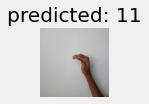

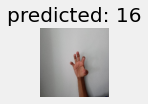

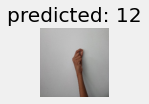

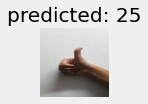

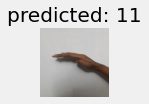

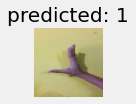

In [ ]:
visualize_model(model_vgg)

In [ ]:
torch.save(model_vgg.state_dict(), "BSL_Vgg16.pt")

In [ ]:
val_Loss

[0.32731179124430604,
 0.33321709125057647,
 0.2918255095811267,
 0.3715373181198773,
 0.41794775907489423]

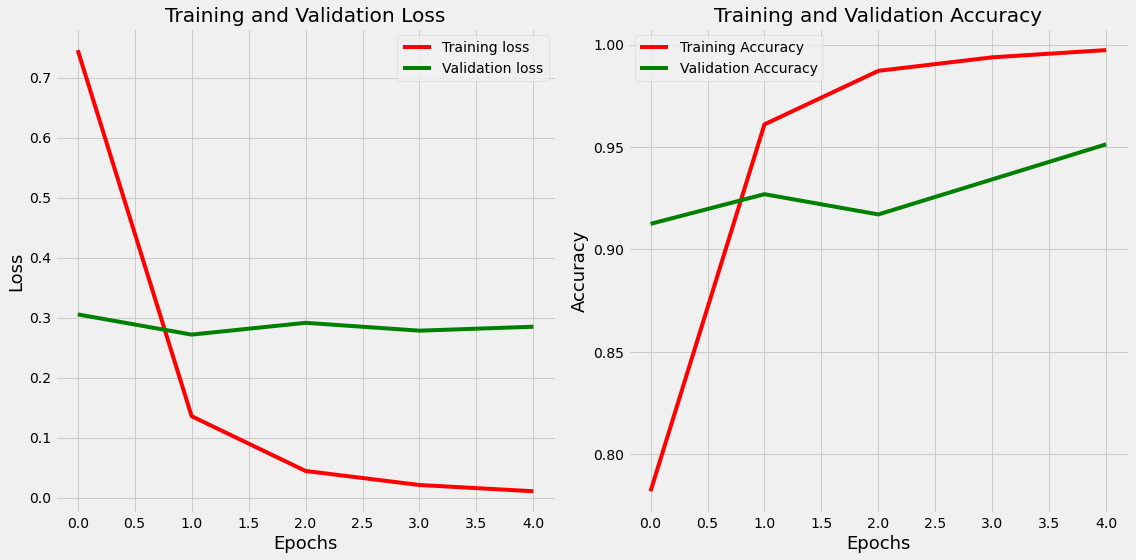

In [ ]:
def plot_auc_acc_loss(epochs):

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, train_Loss, 'r', label='Training loss')
    axes[0].plot(Epochs, val_Loss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    train_Acc2=torch.FloatTensor(train_Acc).detach().cpu().numpy()
    val_Acc2=torch.FloatTensor(val_Acc).detach().cpu().numpy()
    axes[1].plot(Epochs, train_Acc2, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, val_Acc2, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()


    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(epochs=5)

In [102]:
correct = 0
total = 0

predictions_list = []
labels_list = []
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        labels_list.append(labels) 
        outputs = model_vgg(images)
        
        _, predicted = torch.max(outputs.data, 1)
        predictions_list.append(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test images:  95.13157894736842 %


In [103]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [104]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      1.00      1.00        40
           2       0.97      0.93      0.95        40
           3       0.97      0.97      0.97        40
           4       0.92      0.85      0.88        40
           5       0.90      0.93      0.91        40
           6       0.93      0.95      0.94        40
           7       0.89      0.97      0.93        40
           8       0.97      0.97      0.97        40
           9       1.00      1.00      1.00        40
          10       0.93      0.93      0.93        40
          11       0.95      1.00      0.98        40
          12       0.97      0.97      0.97        40
          13       1.00      0.97      0.99        40
          14       0.93      0.97      0.95        40
          15       0.69      0.85      0.76        40
          16       1.00      0.90      0.95      

In [105]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns

prec_score = precision_score(labels_l,predictions_l, average='weighted') * 100
rec_score = recall_score(labels_l, predictions_l, average='weighted') * 100
f1score = f1_score(labels_l, predictions_l, average='weighted') * 100

print(f'precision score was {prec_score:6.2f}%\nrecall score was {rec_score:6.2f}%')
print(f'f1 score was {f1score:6.2f}%\n')

precision score was  95.30%
recall score was  95.13%
f1 score was  95.12%



# Mobilenet_V3_small

### thik code

In [78]:
# super simplified
import torchvision.models as models
model_mobilenet = models.mobilenet_v3_small(pretrained=True)

for param in model_mobilenet.parameters():
  param.requires_grad = True
num_ftrs = model_mobilenet.classifier[0].in_features
model_mobilenet.classifier = nn.Linear(num_ftrs,38)
model_mobilenet  = model_mobilenet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [ ]:
num_ftrs

576

In [79]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# We create an optimizer, in this case, SGD with a learning rate of 0.006 and register all the parameters of the model in the optimizer. Observe that all parameters are being optimized
optimizer = optim.SGD(model_mobilenet.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
# lr = 0.006 if epoch < 3
# lr = 0.0006 if 3 <= epoch < 6
# lr = 0.00006 if 6 <= epoch < 9
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [80]:
model_mobilenet = train_model(model_mobilenet, criterion, optimizer, exp_lr_scheduler,  num_epochs=5)

Epoch 0/4 at 11:07:51 AM (01 Dec 2022)
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.5957 Acc: 0.6069
test Loss: 0.5565 Acc: 0.8526
Epoch 1/4 at 11:08:20 AM (01 Dec 2022)
----------
train Loss: 0.3664 Acc: 0.8993
test Loss: 0.4162 Acc: 0.8678
Epoch 2/4 at 11:08:50 AM (01 Dec 2022)
----------
train Loss: 0.2069 Acc: 0.9479
test Loss: 0.2669 Acc: 0.9250
Epoch 3/4 at 11:09:22 AM (01 Dec 2022)
----------
train Loss: 0.1786 Acc: 0.9555
test Loss: 0.2462 Acc: 0.9276
Epoch 4/4 at 11:09:56 AM (01 Dec 2022)
----------
train Loss: 0.1629 Acc: 0.9618
test Loss: 0.2485 Acc: 0.9283
Training complete in 2m 35s
Best val Acc: 0.928289


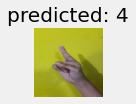

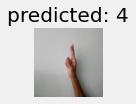

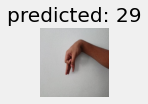

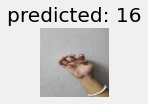

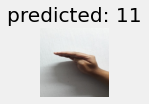

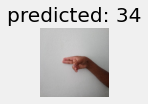

In [81]:
visualize_model(model_mobilenet)

In [82]:
torch.save(model_mobilenet.state_dict(), "BSL_mobilenet_v3_small.pt")

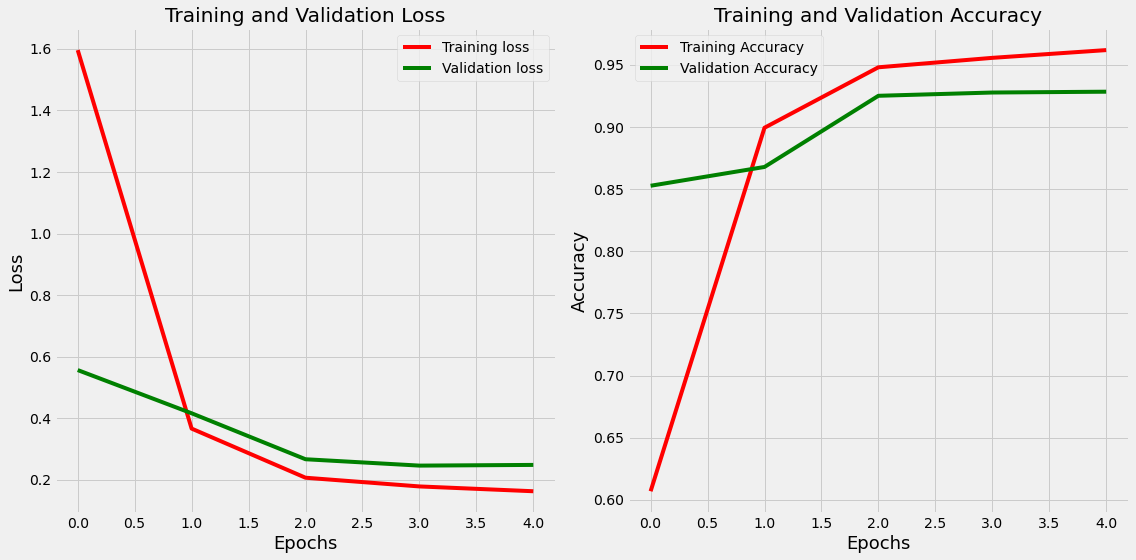

In [83]:
def plot_auc_acc_loss(epochs):

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, train_Loss, 'r', label='Training loss')
    axes[0].plot(Epochs, val_Loss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    train_Acc2=torch.FloatTensor(train_Acc).detach().cpu().numpy()
    val_Acc2=torch.FloatTensor(val_Acc).detach().cpu().numpy()
    axes[1].plot(Epochs, train_Acc2, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, val_Acc2, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()


    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(epochs=5)

In [98]:
correct = 0
total = 0

predictions_list = []
labels_list = []
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        labels_list.append(labels) 
        outputs = model_mobilenet(images)
        
        _, predicted = torch.max(outputs.data, 1)
        predictions_list.append(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test images:  92.82894736842105 %


In [99]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [100]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.98      1.00      0.99        40
           2       0.94      0.85      0.89        40
           3       0.93      1.00      0.96        40
           4       0.95      0.88      0.91        40
           5       0.90      0.93      0.91        40
           6       0.95      0.90      0.92        40
           7       0.95      0.90      0.92        40
           8       0.97      0.93      0.95        40
           9       1.00      1.00      1.00        40
          10       0.90      0.90      0.90        40
          11       0.91      0.97      0.94        40
          12       1.00      0.95      0.97        40
          13       0.97      0.93      0.95        40
          14       0.95      1.00      0.98        40
          15       0.63      0.93      0.75        40
          16       0.88      0.70      0.78      

In [101]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns

prec_score = precision_score(labels_l,predictions_l, average='weighted') * 100
rec_score = recall_score(labels_l, predictions_l, average='weighted') * 100
f1score = f1_score(labels_l, predictions_l, average='weighted') * 100

print(f'precision score was {prec_score:6.2f}%\nrecall score was {rec_score:6.2f}%')
print(f'f1 score was {f1score:6.2f}%\n')

precision score was  93.44%
recall score was  92.83%
f1 score was  92.82%



# Mobilenet_V2

In [ ]:
# super simplified
import torchvision.models as models
model_mobilenetv2 = models.mobilenet_v2(pretrained=True)

for param in model_mobilenetv2.parameters():
  param.requires_grad = True
model_mobilenetv2.classifier = nn.Linear(1280,38)
model_mobilenetv2  = model_mobilenetv2.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# We create an optimizer, in this case, SGD with a learning rate of 0.006 and register all the parameters of the model in the optimizer. Observe that all parameters are being optimized
optimizer = optim.SGD(model_mobilenetv2.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
# lr = 0.006 if epoch < 3
# lr = 0.0006 if 3 <= epoch < 6
# lr = 0.00006 if 6 <= epoch < 9
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_mobilenetv2 = train_model(model_mobilenetv2, criterion, optimizer, exp_lr_scheduler,  num_epochs=5)

Epoch 0/4 at 10:08:06 AM (01 Dec 2022)
----------
train Loss: 0.7545 Acc: 0.7884
test Loss: 0.3579 Acc: 0.8829
Epoch 1/4 at 10:08:56 AM (01 Dec 2022)
----------
train Loss: 0.1900 Acc: 0.9422
test Loss: 0.2696 Acc: 0.9211
Epoch 2/4 at 10:09:46 AM (01 Dec 2022)
----------
train Loss: 0.0824 Acc: 0.9776
test Loss: 0.1533 Acc: 0.9493
Epoch 3/4 at 10:10:36 AM (01 Dec 2022)
----------
train Loss: 0.0481 Acc: 0.9892
test Loss: 0.1444 Acc: 0.9553
Epoch 4/4 at 10:11:31 AM (01 Dec 2022)
----------
train Loss: 0.0377 Acc: 0.9917
test Loss: 0.1491 Acc: 0.9533
Training complete in 4m 14s
Best val Acc: 0.955263


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


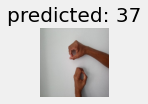

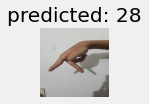

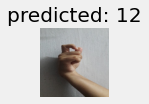

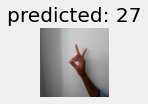

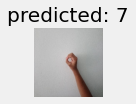

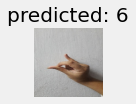

In [ ]:
visualize_model(model_mobilenetv2)

In [ ]:
torch.save(model_mobilenetv2.state_dict(), "BSL_mobilenet_v2.pt")

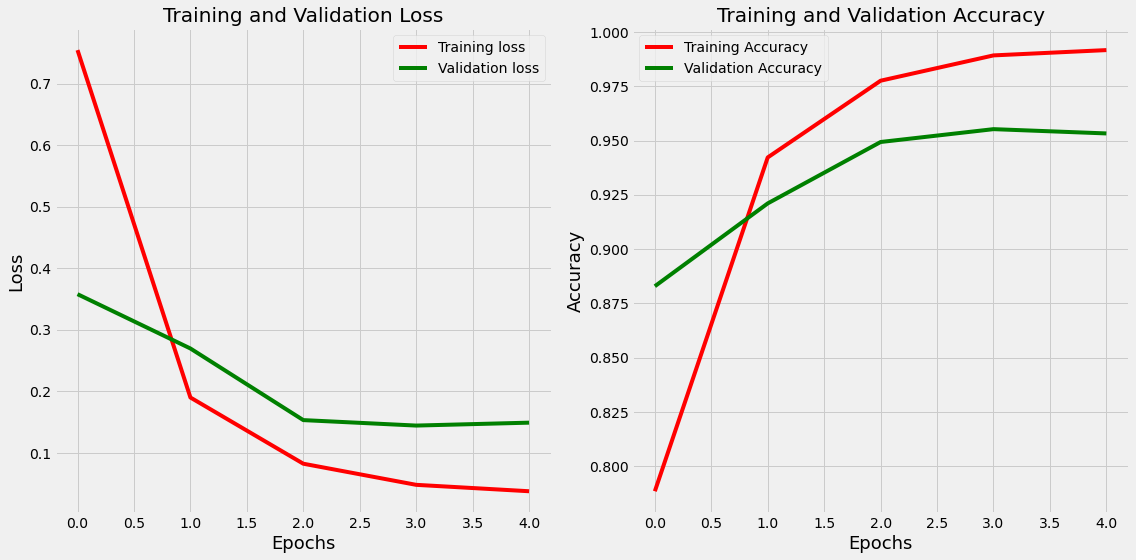

In [ ]:
def plot_auc_acc_loss(epochs):

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, train_Loss, 'r', label='Training loss')
    axes[0].plot(Epochs, val_Loss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    train_Acc2=torch.FloatTensor(train_Acc).detach().cpu().numpy()
    val_Acc2=torch.FloatTensor(val_Acc).detach().cpu().numpy()
    axes[1].plot(Epochs, train_Acc2, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, val_Acc2, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()


    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(epochs=5)

In [94]:
correct = 0
total = 0

predictions_list = []
labels_list = []
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        labels_list.append(labels) 
        outputs = model_mobilenetv2(images)
        
        _, predicted = torch.max(outputs.data, 1)
        predictions_list.append(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test images:  95.52631578947368 %


In [95]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [96]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        40
           1       0.95      0.97      0.96        40
           2       1.00      0.93      0.96        40
           3       0.95      1.00      0.98        40
           4       0.90      0.90      0.90        40
           5       0.95      0.90      0.92        40
           6       1.00      0.95      0.97        40
           7       1.00      0.97      0.99        40
           8       0.97      0.97      0.97        40
           9       1.00      1.00      1.00        40
          10       0.88      0.95      0.92        40
          11       0.97      0.97      0.97        40
          12       0.97      0.97      0.97        40
          13       1.00      0.97      0.99        40
          14       0.95      1.00      0.98        40
          15       0.73      0.90      0.81        40
          16       0.97      0.93      0.95      

In [97]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns

prec_score = precision_score(labels_l,predictions_l, average='weighted') * 100
rec_score = recall_score(labels_l, predictions_l, average='weighted') * 100
f1score = f1_score(labels_l, predictions_l, average='weighted') * 100

print(f'precision score was {prec_score:6.2f}%\nrecall score was {rec_score:6.2f}%')
print(f'f1 score was {f1score:6.2f}%\n')

precision score was  95.72%
recall score was  95.53%
f1 score was  95.52%



# Resnet50

In [ ]:
# super simplified
import torchvision.models as models
model_resnet = models.resnet50(pretrained=True)

for param in model_resnet.parameters():
  param.requires_grad = True

model_resnet.classifier = nn.Linear(1024,38)
model_resnet = model_resnet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# We create an optimizer, in this case, SGD with a learning rate of 0.006 and register all the parameters of the model in the optimizer. Observe that all parameters are being optimized
optimizer = optim.SGD(model_resnet.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
# lr = 0.006 if epoch < 3
# lr = 0.0006 if 3 <= epoch < 6
# lr = 0.00006 if 6 <= epoch < 9
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler,  num_epochs=5)

Epoch 0/4 at 10:18:20 AM (01 Dec 2022)
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.8102 Acc: 0.7931
test Loss: 0.3702 Acc: 0.8901
Epoch 1/4 at 10:20:21 AM (01 Dec 2022)
----------
train Loss: 0.2083 Acc: 0.9345
test Loss: 0.2096 Acc: 0.9349
Epoch 2/4 at 10:22:24 AM (01 Dec 2022)
----------
train Loss: 0.0602 Acc: 0.9833
test Loss: 0.1302 Acc: 0.9572
Epoch 3/4 at 10:24:27 AM (01 Dec 2022)
----------
train Loss: 0.0402 Acc: 0.9901
test Loss: 0.1276 Acc: 0.9632
Epoch 4/4 at 10:26:30 AM (01 Dec 2022)
----------
train Loss: 0.0299 Acc: 0.9932
test Loss: 0.1316 Acc: 0.9605
Training complete in 10m 12s
Best val Acc: 0.963158


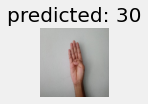

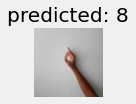

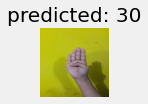

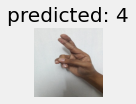

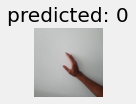

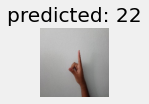

In [ ]:
visualize_model(model_resnet)

In [ ]:
torch.save(model_resnet.state_dict(), "BSL_resnet50.pt")

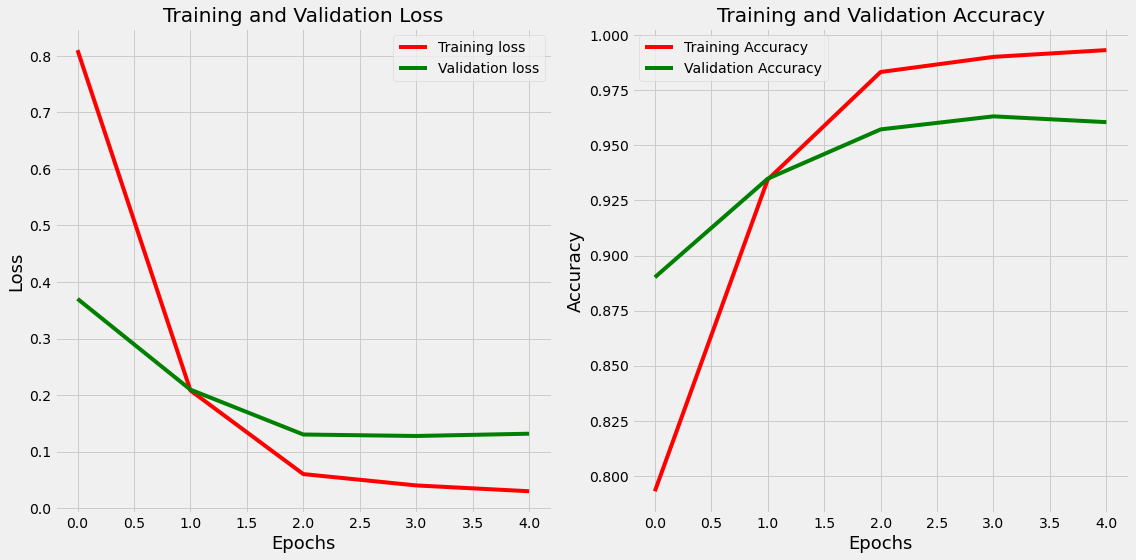

In [ ]:
def plot_auc_acc_loss(epochs):

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, train_Loss, 'r', label='Training loss')
    axes[0].plot(Epochs, val_Loss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    train_Acc2=torch.FloatTensor(train_Acc).detach().cpu().numpy()
    val_Acc2=torch.FloatTensor(val_Acc).detach().cpu().numpy()
    axes[1].plot(Epochs, train_Acc2, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, val_Acc2, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()


    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(epochs=5)

In [90]:
correct = 0
total = 0

predictions_list = []
labels_list = []
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        labels_list.append(labels) 
        outputs = model_resnet(images)
        
        _, predicted = torch.max(outputs.data, 1)
        predictions_list.append(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test images:  96.3157894736842 %


In [91]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [92]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        40
           1       0.97      0.97      0.97        40
           2       1.00      0.95      0.97        40
           3       0.98      1.00      0.99        40
           4       0.95      0.93      0.94        40
           5       0.90      0.95      0.93        40
           6       0.90      0.95      0.93        40
           7       0.95      0.95      0.95        40
           8       0.97      0.97      0.97        40
           9       1.00      1.00      1.00        40
          10       0.95      0.90      0.92        40
          11       0.95      1.00      0.98        40
          12       1.00      1.00      1.00        40
          13       0.97      0.97      0.97        40
          14       0.98      1.00      0.99        40
          15       0.76      0.88      0.81        40
          16       1.00      0.95      0.97      

In [93]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns

prec_score = precision_score(labels_l,predictions_l, average='weighted') * 100
rec_score = recall_score(labels_l, predictions_l, average='weighted') * 100
f1score = f1_score(labels_l, predictions_l, average='weighted') * 100

print(f'precision score was {prec_score:6.2f}%\nrecall score was {rec_score:6.2f}%')
print(f'f1 score was {f1score:6.2f}%\n')

precision score was  96.42%
recall score was  96.32%
f1 score was  96.30%

